In [1]:
import ee
import xarray as xr
import geemap


In [2]:
ee.Authenticate()
ee.Initialize (
    project = 'brilliant-rhino-344309',
    opt_url = 'https://earthengine-highvolume.googleapis.com')


In [3]:
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [5]:
roi = map.draw_last_feature.geometry()

sen2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")                                       # type: ignore
    .linkCollection(
        ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY"),'probability'                 # type: ignore
        )
    .filterBounds(roi)
    .filterDate('2024','2025')) 



Now we have our Sentinel-2 images we targeted, now we want to convert this images to get the TSS(Total Suspended Solid) by using a calculation of multi spectral bands. This function will take the collection of images, remove any cloudy pixels and create a new collection where each image contains only the TSS values for water pixels with minimal cloud cover.

**Note**: The TSS formula used is a band-ratio based estimator that correlates with suspended sediment concentration in water bodies.

**index(img)** processes each satellite image through these steps:

1. Cloud Masking: `cloud_band.lt(20)` - Removes pixels with >20% cloud probability 
2. Band Scaling: `multiply(0.0001)` - Converts Sentinel-2 reflectance values to proper scale
3. Water Detection:
    - Calculates NDWI (Normalized Difference Water Index) using bands B3 (green) and B8 (NIR)
    - `ndwi.gt(0.1)` - Identifies water bodies (NDWI > 0.1 indicates water)
4. TSS Calculation: Uses the formula $B7 * (B5/B2)$ where:
    - B2: Blue band
    - B5: Red-edge band
    - B7: Another red-edge band
5. Mask Application: Applies both cloud and water masks to the TSS result
6. Property Preservation: copyProperties() - Maintains original image metadata (especially timestamp)

In [6]:
def index(img):                                    #processes each satellite image
    cloud_band = img.select('probability')
    cloud_free = cloud_band.lt(20)                  #Removes pixels with >20% cloud probability
    ms_band = img.select('B.*').multiply(0.0001)    #Converts Sentinel-2 reflectance values to proper scale
    ndwi = ms_band.normalizedDifference(['B3','B8']).rename('ndwi') #Calculates NDWI (Normalized Difference Water Index) using bands B3 (green) and B8 (NIR)
    water_body = ndwi.gt(0.1)                       #Identifies water bodies (NDWI > 0.1 indicates water)
    tss = ms_band.expression('b7 * (b5/b2)', {'b2':ms_band.select('B2'),'b5':ms_band.select('B5'),'b7':ms_band.select('B7')}).rename('tss') #Uses formula to calculate TSS 
    return tss.updateMask(cloud_free).updateMask(water_body).copyProperties(img, ['system:time_start']) #Applies both cloud and water masks to the TSS result and Maintains original image metadata

sen2_index = sen2.map(index)

In [ ]:
ds = xr.open_dataset(sen2_index,
                     engine= 'ee',
                     crs = 'EPSG:4326',
                     scale = 0.001,
                     geometry = roi)

ds = ds.sortby('time') * 1

<Axes: xlabel='time'>

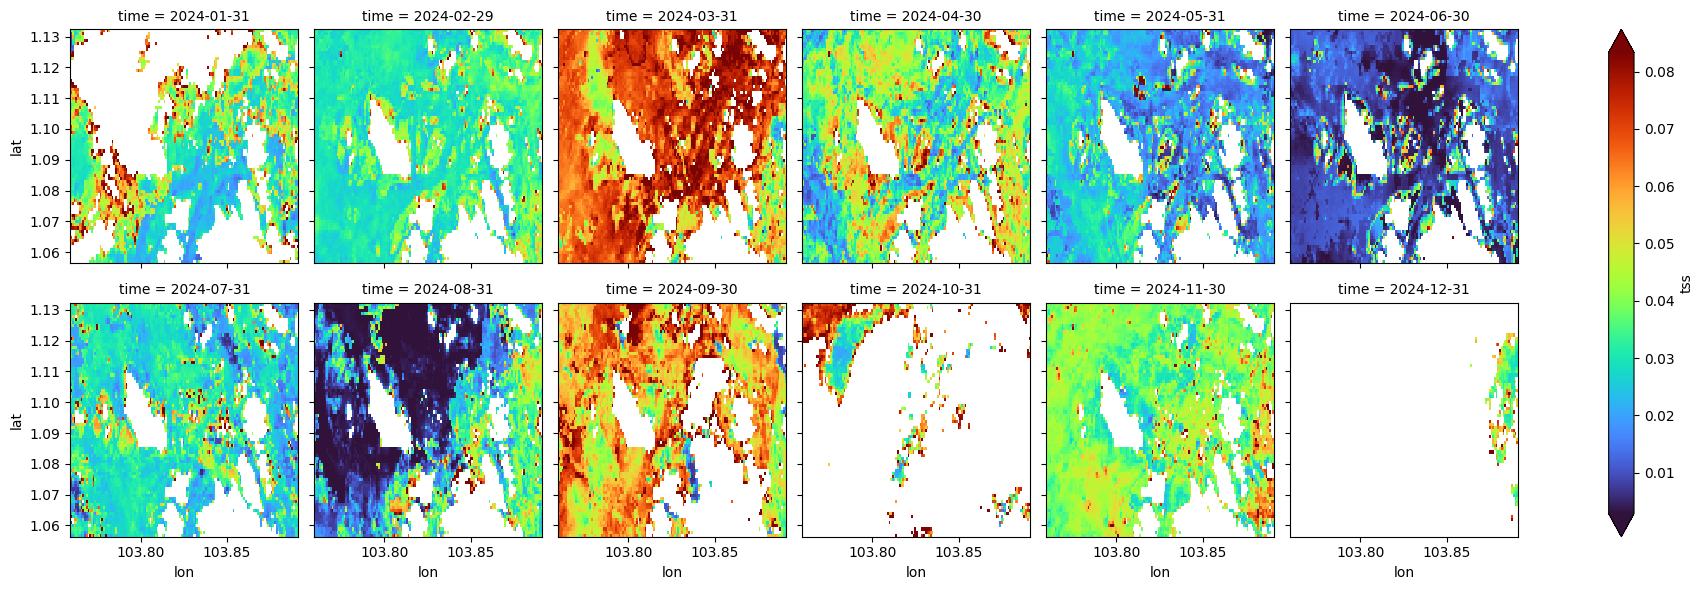

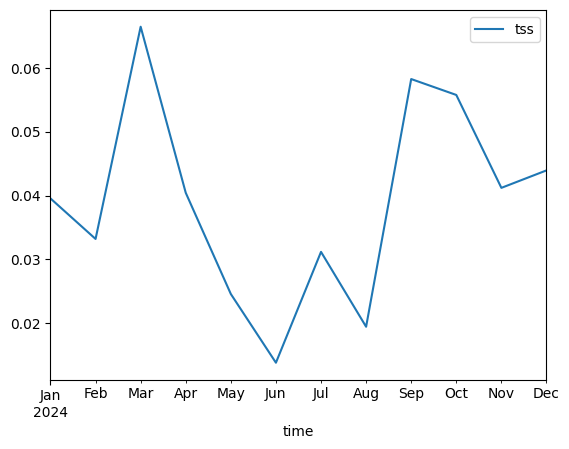

In [ ]:
ds_monthly = ds.resample(time = 'M').median('time')
ds_monthly.tss.plot(x = 'lon',y='lat',col = 'time',col_wrap = 6, robust = True,cmap = 'turbo')

monthly_mean = ds_monthly.mean(dim = ['lat','lon'])
monthly_df = monthly_mean.to_dataframe()
monthly_df.plot()